## Importing Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Data and preprocessing

In [44]:
df = pd.read_csv('/content/AMZN.csv')

In [45]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [46]:
## We only need the closing values and the date
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


<ipython-input-47-9ad2e75ea0f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


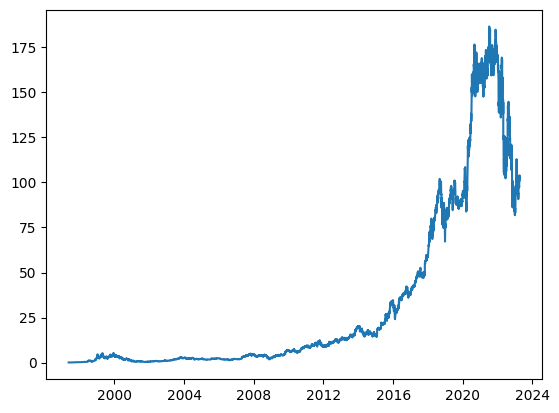

In [47]:
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df['Close'])

In [48]:
from copy import deepcopy as dc
def prepare_df_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_df_for_lstm(df, lookback)
shifted_df.head()


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [49]:
X = shifted_df.iloc[:, 1:].values
y = shifted_df.iloc[:, 0].values

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1,1))

X

array([[-0.99995531, -1.        , -0.99998325, ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99991063, -0.99994415, -1.        , ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99993855, -0.99989946, -0.99994415, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.10690997,  0.09308121,  0.07431453, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.09747299,  0.10691495,  0.09308121, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.11398769,  0.09747802,  0.10691495, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [51]:
X = dc(np.flip(X, axis=1)) ## Flipping for LSTM

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5207, 7), (1302, 7), (5207, 1), (1302, 1))

## Data class

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reshape(-1, lookback, 1)
        self.y = y.reshape(-1, 1)

        self.X = torch.tensor(self.X).float().to(device)
        self.y = torch.tensor(self.y).float().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [56]:
train_data = TimeSeriesDataset(X_train, y_train)
test_data = TimeSeriesDataset(X_test, y_test)

In [57]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Model Making

In [58]:
class ForecastingModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_stacked_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

model = ForecastingModel(1, 64, 2)
model.to(device)
model

ForecastingModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [59]:
learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    print(f"Epoch: {epoch + 1}")
    training_loss = 0.0

    for batch_idx, (X, y) in enumerate(tqdm(train_loader)):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Optimizer compulse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f"Training loss: {training_loss/len(train_loader)}")

    model.eval()
    testing_loss = 0.0
    for batch_idx, (X, y) in enumerate(tqdm(test_loader)):
        with torch.inference_mode():
            output = model(X)
            loss = loss_fn(output, y)

            testing_loss += loss.item()

    print(f"Testing loss: {testing_loss/len(test_loader)}")
    print("...")

Epoch: 1


100%|██████████| 326/326 [00:00<00:00, 423.15it/s]


Training loss: 0.02523823236143566


100%|██████████| 82/82 [00:00<00:00, 1236.17it/s]


Testing loss: 0.21041330321487495
...
Epoch: 2


100%|██████████| 326/326 [00:00<00:00, 416.42it/s]


Training loss: 6.681820655926375e-05


100%|██████████| 82/82 [00:00<00:00, 1363.67it/s]


Testing loss: 0.13241399823483535
...
Epoch: 3


100%|██████████| 326/326 [00:00<00:00, 418.70it/s]


Training loss: 4.109160056556618e-05


100%|██████████| 82/82 [00:00<00:00, 1418.64it/s]


Testing loss: 0.10504951484986899
...
Epoch: 4


100%|██████████| 326/326 [00:00<00:00, 419.35it/s]


Training loss: 4.545835601948614e-05


100%|██████████| 82/82 [00:00<00:00, 1104.16it/s]


Testing loss: 0.10032669845230241
...
Epoch: 5


100%|██████████| 326/326 [00:00<00:00, 432.66it/s]


Training loss: 4.723542570744231e-05


100%|██████████| 82/82 [00:00<00:00, 1350.53it/s]


Testing loss: 0.09935570931595909
...
Epoch: 6


100%|██████████| 326/326 [00:00<00:00, 416.08it/s]


Training loss: 4.680350619441171e-05


100%|██████████| 82/82 [00:00<00:00, 1418.51it/s]


Testing loss: 0.09628221464894213
...
Epoch: 7


100%|██████████| 326/326 [00:00<00:00, 421.48it/s]


Training loss: 5.4876826529165376e-05


100%|██████████| 82/82 [00:00<00:00, 1212.35it/s]


Testing loss: 0.09142358018093878
...
Epoch: 8


100%|██████████| 326/326 [00:00<00:00, 424.43it/s]


Training loss: 4.721756424979877e-05


100%|██████████| 82/82 [00:00<00:00, 1412.72it/s]


Testing loss: 0.0857413713323384
...
Epoch: 9


100%|██████████| 326/326 [00:00<00:00, 353.71it/s]


Training loss: 5.0325501663853616e-05


100%|██████████| 82/82 [00:00<00:00, 1076.28it/s]


Testing loss: 0.07730330669011626
...
Epoch: 10


100%|██████████| 326/326 [00:01<00:00, 315.93it/s]


Training loss: 6.0703206252672464e-05


100%|██████████| 82/82 [00:00<00:00, 963.48it/s]

Testing loss: 0.07978985562747368
...


In [66]:
def data_to_lstm(X):
    X = X.reshape(-1, lookback, 1)
    X = torch.tensor(X).float().to(device)
    return X

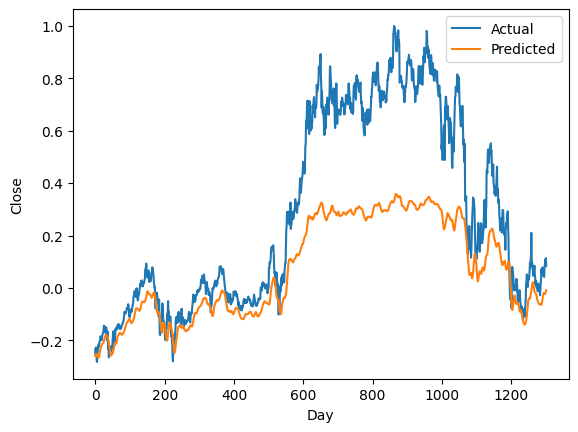

In [67]:
with torch.no_grad():
    predicted = model(data_to_lstm(X_test)).to('cpu').numpy()

plt.plot(y_test, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## Saving the model

In [68]:
PATH = "/content/model.pth"
torch.save(model.state_dict(), PATH)